In [2]:
suppressMessages(library(Seurat))
suppressMessages(library(tidyverse))
library(ggsci)

In [20]:
seuratobj_full=readRDS('/mnt/MXMERZ002A/LargeData/seuratobj_1.rds')
metadata=seuratobj_full@meta.data
#metadata2=read_csv('/mnt/MXMERZ002A/LargeData/seuratobjmetadata.csv', show_col_types = FALSE)

In [21]:
metadata=metadata %>% mutate(timepoint=ifelse(days.since.apharesis<2, 'apharesis','post_infusion')) %>% 
mutate(response=ifelse(remission.after.CAR=='CR', 'CR', 'nonCR')) %>%
mutate(WNN_l2=ifelse(WNN_l2=='Plasmablast', 'Plasma cells', WNN_l2))

In [22]:
# Identify CAR
idecabtagene_bc=colnames(seuratobj_full)[GetAssayData(seuratobj_full, slot='counts', assay = 'RNA')['idecabtagene',]>0]
ciltacabtagene_bc=colnames(seuratobj_full)[GetAssayData(seuratobj_full, slot='counts', assay = 'RNA')['ciltacabtagene',]>0]
metadata[rownames(metadata) %in% union(idecabtagene_bc, ciltacabtagene_bc), 'WNN_l2']='CAR-T'

In [57]:
apharesis=metadata %>% filter(timepoint=='apharesis') %>%
#filter(!WNN_l2 %in% c('Eryth' ,'Doublet')) %>%
count(orig.ident, WNN_l2, response, source) %>%
pivot_wider(names_from=WNN_l2, values_from=n, values_fill=0)

In [54]:
apharesis %>% write_csv("./extranotebooks/cellcount_apharesis.csv")

In [26]:
apharesis_credible=read_csv('apharesis_credible.csv', show_col_types = FALSE) %>% select(`Cell Type`, Significant=`Final Parameter`)

In [58]:
apharesis_plot=apharesis %>% pivot_longer(!1:3) 
apharesis_plot=apharesis_plot %>% group_by(orig.ident) %>% mutate(total=sum(value)) %>% ungroup %>% mutate(proportion=value/total)

In [62]:
apharesis_plot %>%
pivot_wider(id_cols=c(orig.ident:source), names_from=name, values_from=proportion, values_fill=0) %>%
write_csv("./extranotebooks/cellprop_apharesis.csv")

In [28]:
apharesis_plot=apharesis_plot %>% left_join(apharesis_credible, by=c(name='Cell Type'))

# Cell composition comparison between CR and nonCR samples
Here we plotted the cell type composition in CR and nonCR samples. For statistical testing, we used scCODA with a FDR of 0.05. Cell type with statistically significant difference are outlined with red. 

## Apharesis PBMC samples

### Sorted by average of CR and nonCR

In [33]:
xaxisorder=apharesis_plot %>% group_by(name) %>% summarise(mean_prop=mean(proportion)) %>% arrange(-mean_prop) %>% select(name) %>% unlist
apharesis_plot=apharesis_plot %>% mutate(name=factor(name, levels=xaxisorder))
textcolor=apharesis_plot %>% distinct(name,.keep_all = T) %>% arrange(name) %>% mutate(color=ifelse(Significant, "red", "black")) %>% select(color) %>% unlist

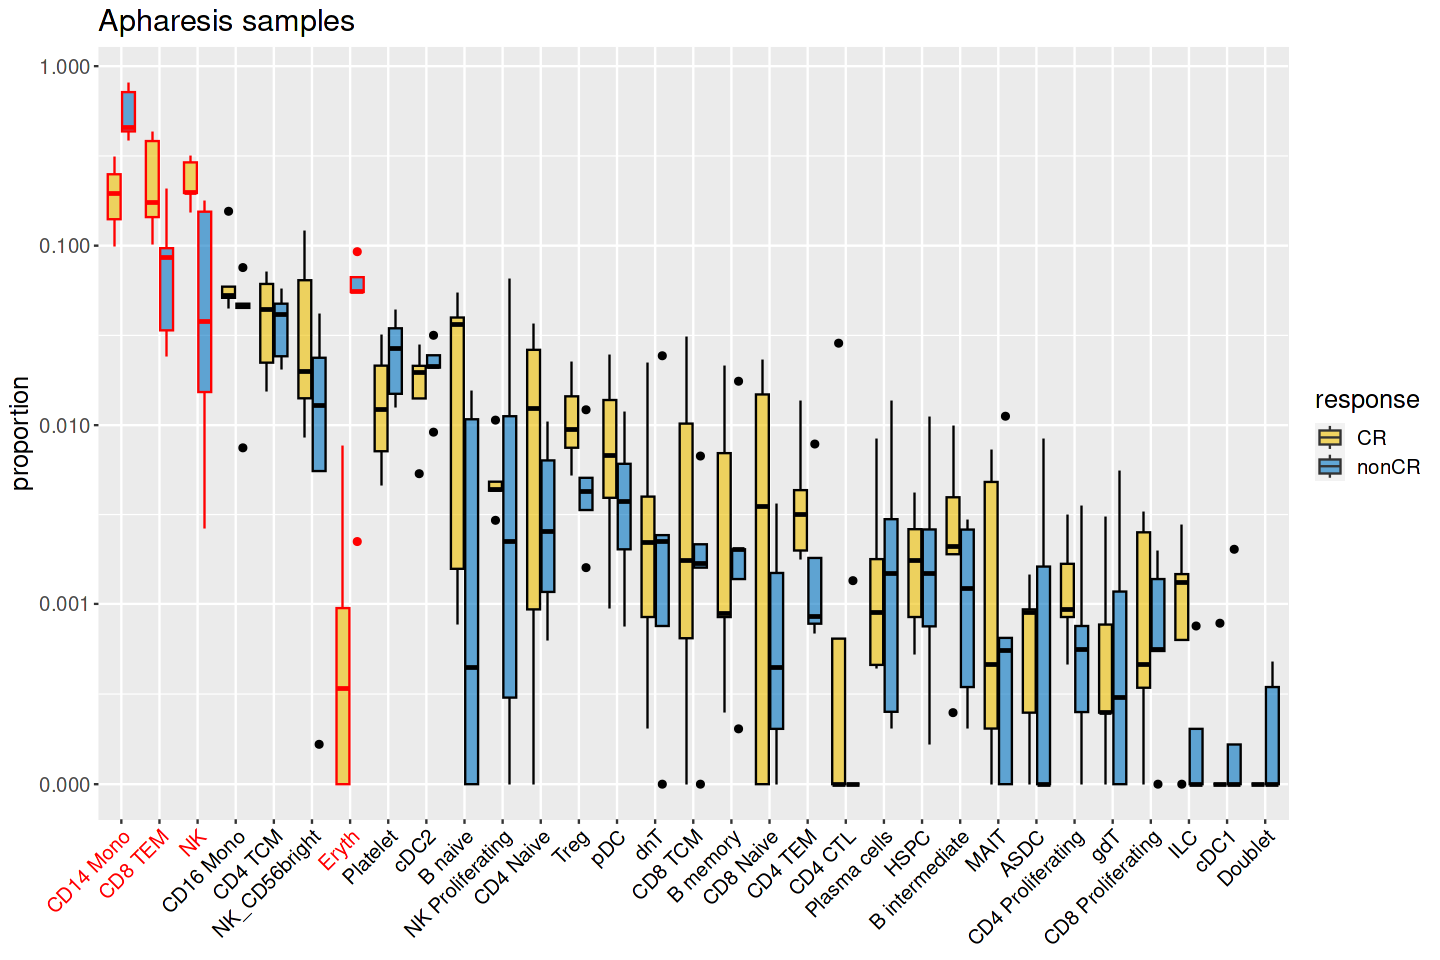

In [34]:
#Figure 4C
options(repr.plot.width=12, repr.plot.height=8, warn=-1)
ggplot(apharesis_plot, aes(x=name, y=proportion, fill=response, color=Significant))+geom_boxplot()+
  scale_color_manual(values=c("black","red"), guide="none")+  
scale_y_continuous(trans=scales::pseudo_log_trans(sigma=0.0001,base = 10), breaks=c(0, 0.001, 0.01, 0.1, 1))+
theme(strip.text.x = element_text(size = 12))+
ggtitle('Apharesis samples')+
theme(text = element_text(size = 15), axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, color=textcolor),axis.title.x=element_blank())+
scale_fill_manual(values = pal_jco("default", alpha = 0.6)(10)[2:1])
options(warn=0)

In [63]:
post_infusion_pb=metadata %>% filter(timepoint=='post_infusion', source=='PB') %>%
#filter(!WNN_l2 %in% c('Eryth' ,'Doublet'))  %>%
count(orig.ident, WNN_l2, response, source) %>%
pivot_wider(names_from=WNN_l2, values_from=n, values_fill=0)

In [64]:
post_infusion_pb %>% write_csv("./extranotebooks/cellcountnocar_postinfusion_pbmc.csv")

In [124]:
postinfusion_pb_credible=read_csv('postinfusionpbmcnocar_credible.csv', show_col_types = FALSE) %>% select(`Cell Type`, Significant=`Final Parameter`)

In [65]:
post_infusion_pb_plot=post_infusion_pb %>% pivot_longer(!1:3) 
post_infusion_pb_plot=post_infusion_pb_plot %>% group_by(orig.ident) %>% mutate(total=sum(value)) %>% ungroup %>% mutate(proportion=value/total)

In [66]:
post_infusion_pb_plot %>%
pivot_wider(id_cols=c(orig.ident:source), names_from=name, values_from=proportion, values_fill=0) %>%
write_csv("./extranotebooks/cellpropnocar_postinfusion_pbmc.csv")

In [126]:
post_infusion_pb_plot=post_infusion_pb_plot %>% left_join(postinfusion_pb_credible, by=c(name='Cell Type'))

## Post infusion PBMC samples

### Sorted by average of CR and nonCR

In [128]:
xaxisorder=post_infusion_pb_plot %>% group_by(name) %>% summarise(mean_prop=mean(proportion)) %>% arrange(-mean_prop) %>% select(name) %>% unlist
post_infusion_pb_plot=post_infusion_pb_plot %>% mutate(name=factor(name, levels=xaxisorder))
textcolor=post_infusion_pb_plot %>% distinct(name,.keep_all = T) %>% arrange(name) %>% mutate(color=ifelse(Significant, "red", "black")) %>% select(color) %>% unlist

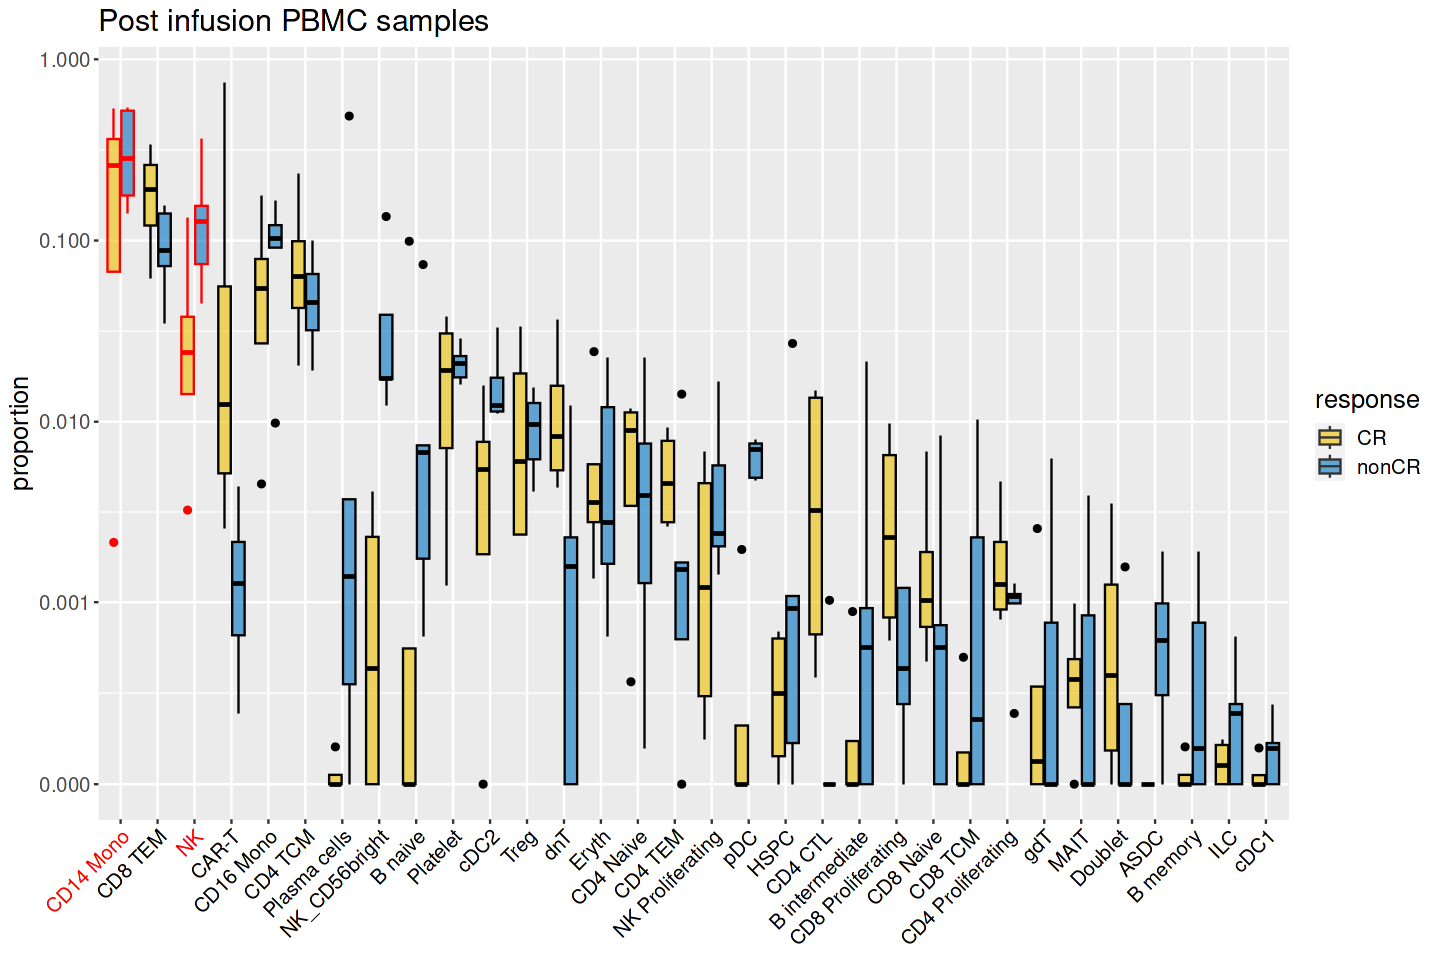

In [129]:
# Figure 3C
# CART treated as separate population
options(repr.plot.width=12, repr.plot.height=8,warn=-1)
ggplot(post_infusion_pb_plot, aes(x=name, y=proportion, fill=response, color=Significant))+geom_boxplot()+
scale_color_manual(values=c("black","red"), guide="none")+
scale_y_continuous(trans=scales::pseudo_log_trans(sigma=0.0001,base = 10), breaks=c(0, 0.001, 0.01, 0.1, 1))+
ggtitle('Post infusion PBMC samples')+
theme(text = element_text(size = 15), axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, color=textcolor),axis.title.x=element_blank())+
scale_fill_manual(values = pal_jco("default", alpha = 0.6)(10)[2:1])

In [70]:
post_infusion_bmmc=metadata %>% filter(timepoint=='post_infusion', source=='BM') %>% 
count(orig.ident, WNN_l2, response, source) %>%
 arrange(WNN_l2) %>%
pivot_wider(names_from=WNN_l2, values_from=n, values_fill=0)

In [71]:
post_infusion_bmmc %>% write_csv("./extranotebooks/cellcountnocar_postinfusion_bm.csv")

In [48]:
postinfusion_bm_credible=read_csv('postinfusionbmmcnocar_credible.csv', show_col_types = FALSE) %>% select(`Cell Type`, Significant=`Final Parameter`)

In [72]:
post_infusion_bmmc_plot=post_infusion_bmmc %>% pivot_longer(!1:3) 
post_infusion_bmmc_plot=post_infusion_bmmc_plot %>% group_by(orig.ident) %>% mutate(total=sum(value)) %>% ungroup %>% mutate(proportion=value/total)

In [73]:
post_infusion_bmmc_plot %>%
pivot_wider(id_cols=c(orig.ident:source), names_from=name, values_from=proportion, values_fill=0) %>%
write_csv("./extranotebooks/cellpropnocar_postinfusion_bm.csv")

In [50]:
post_infusion_bmmc_plot=post_infusion_bmmc_plot %>% left_join(postinfusion_bm_credible, by=c(name='Cell Type'))

## Post infusion BMMC samples

### Sorted by average of CR and nonCR

In [55]:
xaxisorder=post_infusion_bmmc_plot  %>%  group_by(name) %>% summarise(mean_prop=mean(proportion)) %>% arrange(-mean_prop) %>% select(name) %>% unlist
post_infusion_bmmc_plot=post_infusion_bmmc_plot %>% mutate(name=factor(name, levels=xaxisorder))
textcolor=post_infusion_bmmc_plot %>% distinct(name,.keep_all = T) %>% arrange(name) %>% mutate(color=ifelse(Significant, "red", "black")) %>% select(color) %>% unlist

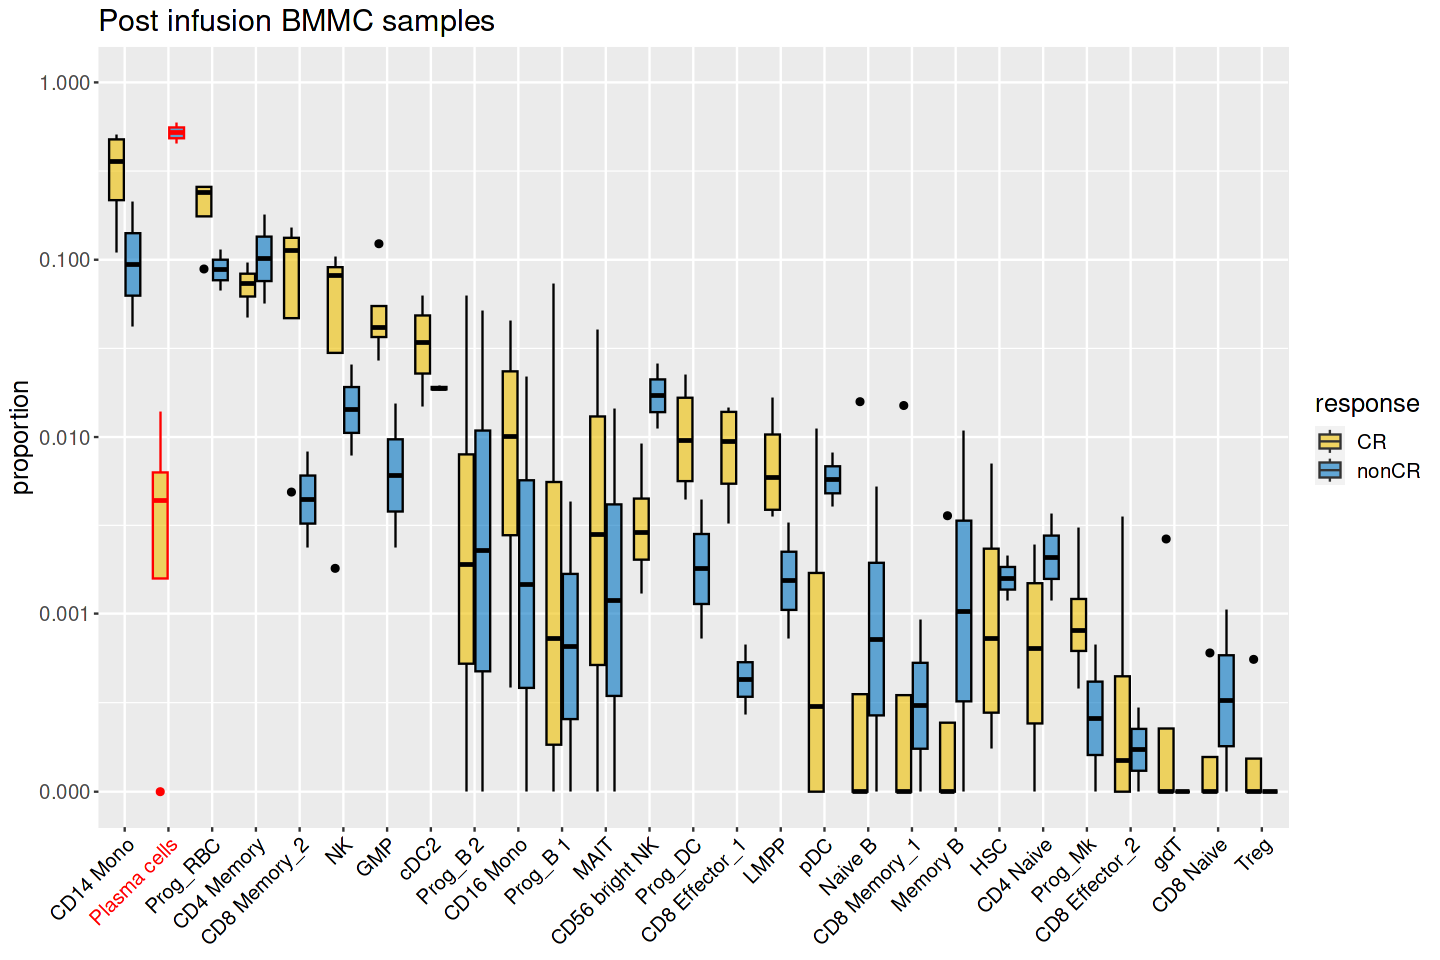

In [56]:
# Supp fig 1C
options(repr.plot.width=12, repr.plot.height=8,warn=-1)
ggplot(post_infusion_bmmc_plot, aes(x=name, y=proportion, fill=response, color=Significant))+geom_boxplot()+
scale_color_manual(values=c("black","red"), guide="none")+
scale_y_continuous(trans=scales::pseudo_log_trans(sigma=0.0001,base = 10), breaks=c(0, 0.001, 0.01, 0.1, 1), limits=c(0,1))+
ggtitle('Post infusion BMMC samples')+
theme(text = element_text(size = 15), axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, color=textcolor),axis.title.x=element_blank())+
scale_fill_manual(values = pal_jco("default", alpha = 0.6)(10)[2:1])